In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import json
import plotly.express as px
import datetime as dt

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv("flipkart_product.csv", encoding='latin1')

In [ ]:
df.head()

,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189874 entries, 0 to 189873
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductName  189874 non-null  object
 1   Price        189873 non-null  object
 2   Rate         189873 non-null  object
 3   Review       189870 non-null  object
 4   Summary      189860 non-null  object
dtypes: object(5)
memory usage: 7.2+ MB


In [ ]:
df.isna().sum()

,0
ProductName,0
Price,1
Rate,1
Review,4
Summary,14


In [ ]:
df.nunique()

,0
ProductName,812
Price,561
Rate,9
Review,1264
Summary,98343


In [ ]:
def is_numeric(val):
    try:
        float(val.replace('₹', '').replace(',', ''))
        return True
    except:
        return False

problematic_rows = df[~df['Price'].apply(is_numeric)]
print(problematic_rows[['Price']])

           Price
0       ??3,999
1       ??3,999
2       ??3,999
3       ??3,999
4       ??3,999
...          ...
189869    â¹142
189870    â¹142
189871    â¹142
189872    â¹142
189873       NaN

[189874 rows x 1 columns]


In [ ]:
def clean_price(price):
    if pd.isna(price):
        return None

    price = str(price).replace('₹', '').replace(',', '')

    cleaned = re.sub(r'[^0-9.]', '', price)
    return cleaned if cleaned else None

df['Price_Cleaned'] = df['Price'].apply(clean_price)

df['Price_Cleaned'] = pd.to_numeric(df['Price_Cleaned'], errors='coerce')

print("Rows with NaN Price after cleaning:", df['Price_Cleaned'].isna().sum())

Rows with NaN Price after cleaning: 1


In [ ]:
df = df.dropna(subset=['Price_Cleaned'])

In [ ]:
median_price = df['Price_Cleaned'].median()
df['Price_Cleaned'] = df['Price_Cleaned'].fillna(median_price)

In [ ]:
print(df[['Price', 'Price_Cleaned']].head(10))

      Price  Price_Cleaned
0  ??3,999         3999.0
1  ??3,999         3999.0
2  ??3,999         3999.0
3  ??3,999         3999.0
4  ??3,999         3999.0
5  ??3,999         3999.0
6  ??3,999         3999.0
7  ??3,999         3999.0
8  ??3,999         3999.0
9  ??3,999         3999.0


In [ ]:
# Handle missing values
df = df.dropna(subset=['Summary'])
df['Review'] = df['Review'].fillna('No review')

# Clean Price (remove ₹ and convert to numeric)
def clean_price(price):
    if pd.isna(price):
        return None
    price = str(price).replace('₹', '').replace(',', '')
    cleaned = re.sub(r'[^0-9.]', '', price)
    return cleaned if cleaned else None

df['Price_Cleaned'] = df['Price'].apply(clean_price)
df['Price_Cleaned'] = pd.to_numeric(df['Price_Cleaned'], errors='coerce')

df = df.dropna(subset=['Price_Cleaned'])


In [ ]:
# Clean Rate (convert to integer, handle odd values)
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')
df = df.dropna(subset=['Rate'])
df['Rate'] = df['Rate'].astype(int)

# Clean ProductName (remove weird characters)
df['ProductName'] = df['ProductName'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))



In [ ]:
# Basic text cleaning for Review and Summary
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['Review'] = df['Review'].apply(clean_text)
df['Summary'] = df['Summary'].apply(clean_text)


with open("jo.json", "r") as file:
    tag_dict = json.load(file)

print(df[['Price', 'Price_Cleaned', 'Rate', 'ProductName']].head())

      Price  Price_Cleaned  Rate  \
0  ??3,999         3999.0     5   
1  ??3,999         3999.0     5   
2  ??3,999         3999.0     3   
3  ??3,999         3999.0     1   
4  ??3,999         3999.0     3   

                                         ProductName  
0  Candes 12 L RoomPersonal Air CoolerWhite Black...  
1  Candes 12 L RoomPersonal Air CoolerWhite Black...  
2  Candes 12 L RoomPersonal Air CoolerWhite Black...  
3  Candes 12 L RoomPersonal Air CoolerWhite Black...  
4  Candes 12 L RoomPersonal Air CoolerWhite Black...  


In [ ]:
print("Unique Rate values:", df['Rate'].unique())

Unique Rate values: [5 3 1 4 2]


In [ ]:
def rate_to_sentiment(rate):
    if rate >= 4:
        return 'Positive'
    elif rate <= 2:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_From_Rate'] = df['Rate'].apply(rate_to_sentiment)


print(df['Sentiment_From_Rate'].value_counts())


Sentiment_From_Rate
Positive    148335
Negative     25841
Neutral      15680
Name: count, dtype: int64


In [ ]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df['Sentiment_Score'] = df['Summary'].apply(lambda x: sia.polarity_scores(x)['compound'])

def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_From_Text'] = df['Sentiment_Score'].apply(classify_sentiment)

print(df['Sentiment_From_Text'].value_counts())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment_From_Text
Positive    150377
Negative     22023
Neutral      17456
Name: count, dtype: int64


In [ ]:
comparison = pd.crosstab(df['Sentiment_From_Rate'], df['Sentiment_From_Text'])
print(comparison)


agreement = (df['Sentiment_From_Rate'] == df['Sentiment_From_Text']).mean()
print(f"Agreement between Rate-based and Text-based sentiment: {agreement:.2%}")

Sentiment_From_Text  Negative  Neutral  Positive
Sentiment_From_Rate                             
Negative                17327     5619      2895
Neutral                  2597     2643     10440
Positive                 2099     9194    137042
Agreement between Rate-based and Text-based sentiment: 82.70%


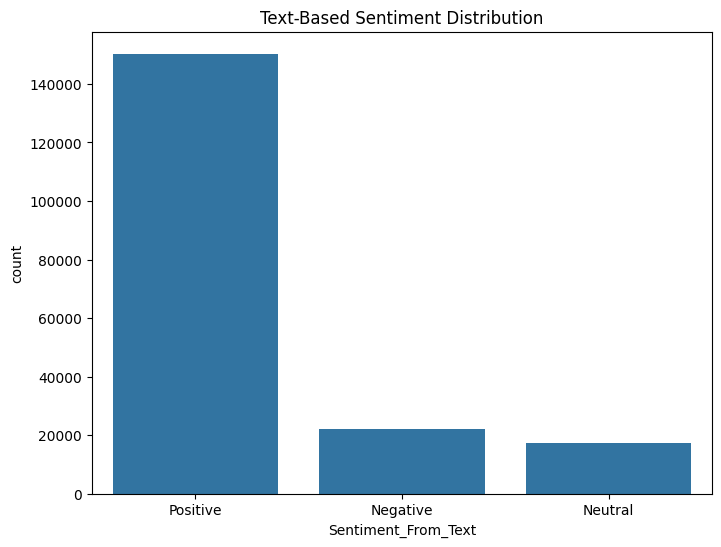

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment_From_Text', data=df)
plt.title('Text-Based Sentiment Distribution')
plt.show()

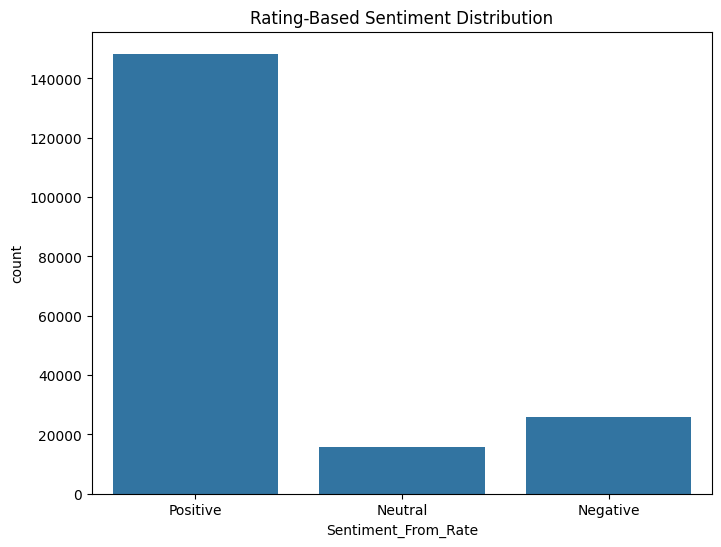

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment_From_Rate', data=df)
plt.title('Rating-Based Sentiment Distribution')
plt.show()

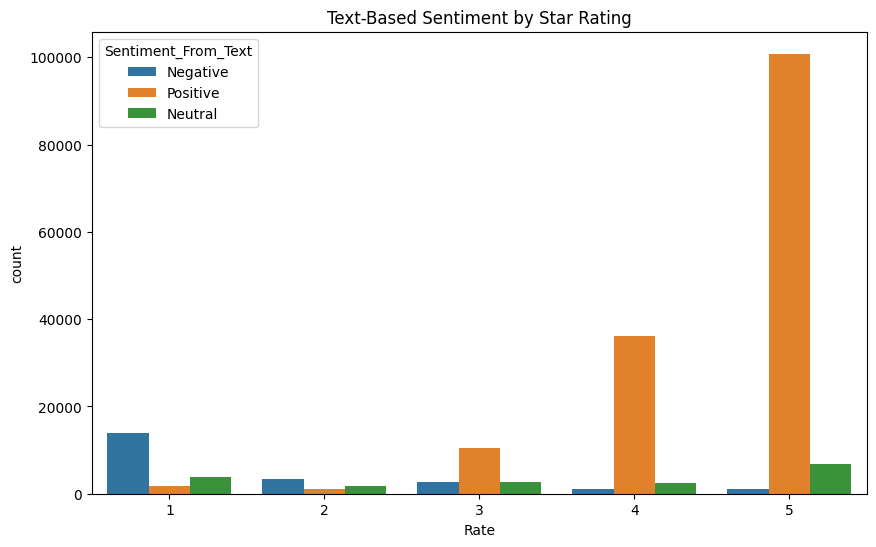

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Rate', hue='Sentiment_From_Text', data=df)
plt.title('Text-Based Sentiment by Star Rating')
plt.show()

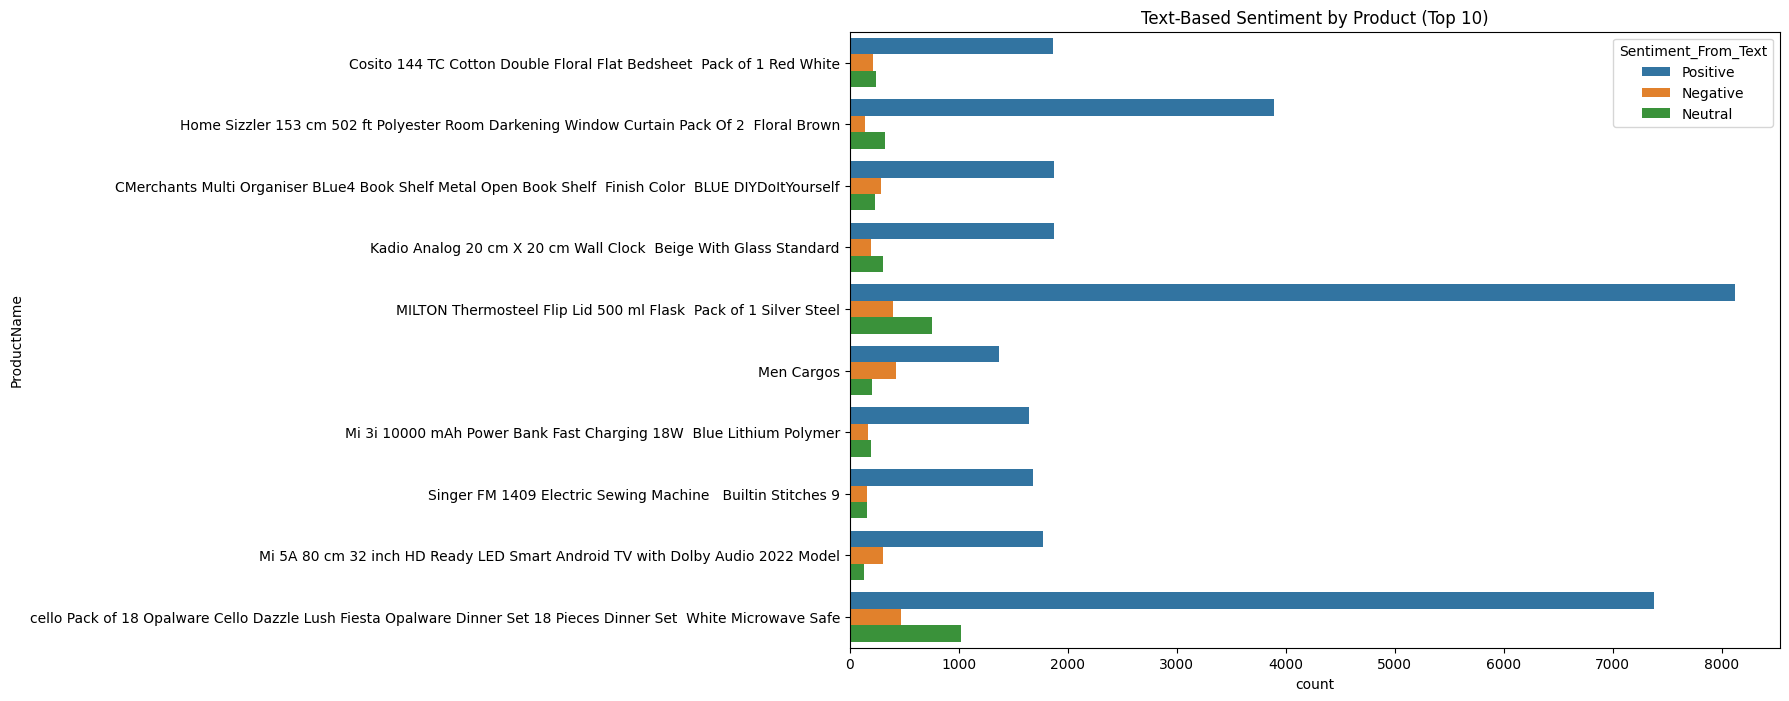

In [ ]:
top_products = df['ProductName'].value_counts().index[:10]
top_df = df[df['ProductName'].isin(top_products)]
plt.figure(figsize=(12, 8))
sns.countplot(y='ProductName', hue='Sentiment_From_Text', data=top_df)
plt.title('Text-Based Sentiment by Product (Top 10)')
plt.show()

In [ ]:
positive_reviews = ' '.join(df[df['Sentiment_From_Text'] == 'Positive']['Summary'])
negative_reviews = ' '.join(df[df['Sentiment_From_Text'] == 'Negative']['Summary'])
neutral_reviews = ' '.join(df[df['Sentiment_From_Text'] == 'Neutral']['Summary'])

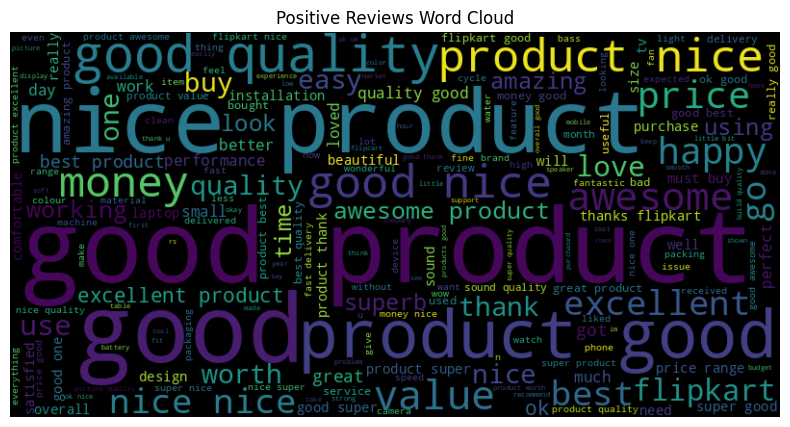

In [ ]:
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(positive_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

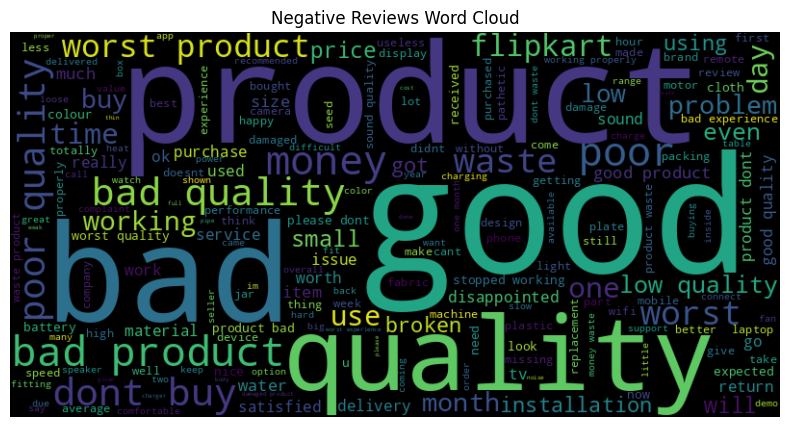

In [ ]:
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(negative_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

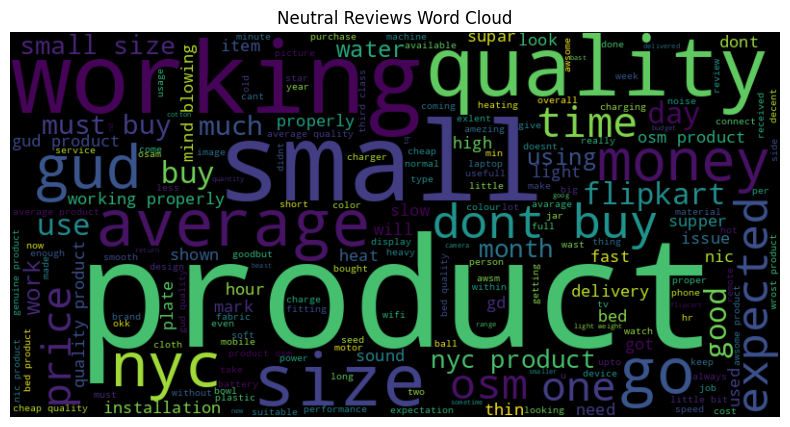

In [ ]:
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(neutral_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Reviews Word Cloud')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
texts = df['Summary'].values
labels = df['Rate'].apply(lambda x: 1 if x >= 4 else (0 if x == 3 else -1)).values

max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

X = pad_sequences(sequences, maxlen=max_len)
y = to_categorical(np.array(labels) + 1, num_classes=3)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/5
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 262s 68ms/step - accuracy: 0.8728 - loss: 0.3922 - val_accuracy: 0.8996 - val_loss: 0.3046
Epoch 2/5
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 262s 68ms/step - accuracy: 0.9051 - loss: 0.2924 - val_accuracy: 0.9020 - val_loss: 0.3020
Epoch 3/5
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 260s 68ms/step - accuracy: 0.9081 - loss: 0.2806 - val_accuracy: 0.9015 - val_loss: 0.3081
Epoch 4/5
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 263s 68ms/step - accuracy: 0.9148 - loss: 0.2630 - val_accuracy: 0.9005 - val_loss: 0.3112
Epoch 5/5
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 261s 68ms/step - accuracy: 0.9207 - loss: 0.2492 - val_accuracy: 0.8977 - val_loss: 0.3257
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9012 - loss: 0.3109
Test Accuracy: 0.8992


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Confusion matrix or classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))

1187/1187 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.85      5242
     Neutral       0.44      0.21      0.29      3038
    Positive       0.93      0.98      0.95     29692

    accuracy                           0.90     37972
   macro avg       0.74      0.68      0.70     37972
weighted avg       0.88      0.90      0.89     37972

